# リポジトリクローン

In [1]:
!git clone https://github.com/Meituan-AutoML/MobileVLM.git
# !git clone --single-branch https://github.com/Meituan-AutoML/MobileVLM.git --branch mobilevlm-v1
%cd MobileVLM

Cloning into 'MobileVLM'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 212 (delta 55), reused 45 (delta 37), pack-reused 133 (from 1)
Receiving objects: 100% (212/212), 490.99 KiB | 12.92 MiB/s, done.
Resolving deltas: 100% (89/89), done.
/content/MobileVLM


# パッケージインストール

In [2]:
!pip install timm==0.9.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

# インポート

In [3]:
import torch
from PIL import Image

from mobilevlm.model.mobilevlm import load_pretrained_model
from mobilevlm.conversation import conv_templates, SeparatorStyle
from mobilevlm.utils import disable_torch_init, process_images, tokenizer_image_token, KeywordsStoppingCriteria

from mobilevlm.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN

# モデルロード

In [4]:
model_path = "mtgv/MobileVLM_V2-1.7B"
# model_path = "mtgv/MobileVLM_V2-3B"
# model_path = "mtgv/MobileVLM_V2-7B"

disable_torch_init()
tokenizer, model, image_processor, context_len = load_pretrained_model(model_path, False, False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.35G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.76k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:2047: UserWarning: for vision_model.embeddings.class_embedding: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(f'for {key}: copying from a non-meta parameter in the checkpoint to a meta '
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:2047: UserWarning: for vision_model.embeddings.patch_embedding.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(f'for {key}: copying from a non-meta parameter in the checkpoint to a meta '
/usr/local/lib/py

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

# 画像読み込み

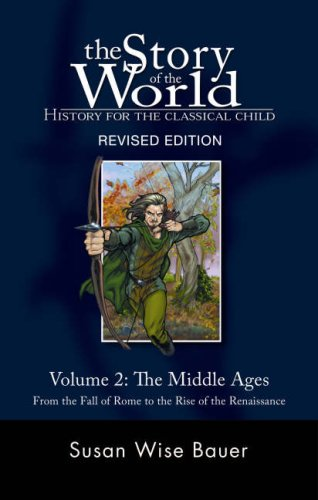

In [5]:
image_path = "assets/samples/demo.jpg"

pil_image = Image.open(image_path).convert("RGB")
images = [pil_image]
images_tensor = process_images(images, image_processor, model.config).to(model.device, dtype=torch.float16)

pil_image

# VLM設定

In [9]:
prompt = "Who is the author of this book?\nAnswer the question using a single word or phrase."

temperature = None  # 0.5など設定する際は、do_sampleをTrueに
do_sample = False
top_p = None
num_beams = 1
max_new_tokens = 512

# 推論

In [14]:
%%time

# プロンプト準備
conv = conv_templates["v1"].copy()
conv.append_message(conv.roles[0], DEFAULT_IMAGE_TOKEN + "\n" + prompt)
conv.append_message(conv.roles[1], None)
input_prompt = conv.get_prompt()

# ID変換
input_ids = (tokenizer_image_token(input_prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).cuda())
stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
stopping_criteria = KeywordsStoppingCriteria([stop_str], tokenizer, input_ids)

# 推論
with torch.inference_mode():
    output_ids = model.generate(
        input_ids,
        images=images_tensor,
        do_sample=do_sample,
        temperature=temperature,
        top_p=top_p,
        num_beams=num_beams,
        max_new_tokens=max_new_tokens,
        use_cache=True,
        stopping_criteria=[stopping_criteria],
    )

# 処理結果デコード
input_token_len = input_ids.shape[1]
n_diff_input_output = (input_ids != output_ids[:, :input_token_len]).sum().item()
if n_diff_input_output > 0:
    print(f"[Warning] {n_diff_input_output} output_ids are not the same as the input_ids")
outputs = tokenizer.batch_decode(output_ids[:, input_token_len:], skip_special_tokens=True)[0]
outputs = outputs.strip()
if outputs.endswith(stop_str):
    outputs = outputs[: -len(stop_str)]

output_text = outputs.strip()

# 表示
print('Model:', model_path.split('/')[-1])
print('Prompt:', prompt)
print('Output:', output_text)
print()

Model: MobileVLM_V2-1.7B
Prompt: Who is the author of this book?
Answer the question using a single word or phrase.
Output: Susan Wise Bauer

CPU times: user 249 ms, sys: 0 ns, total: 249 ms
Wall time: 248 ms


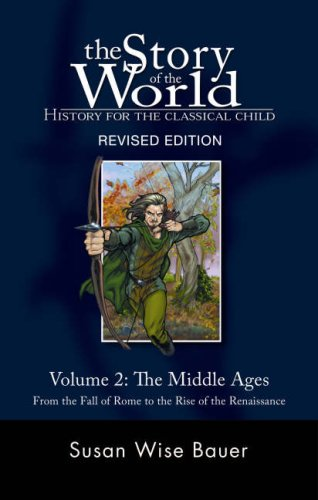

In [12]:
pil_image